In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/vgorti/miniconda3/envs/DIP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:5


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/vgorti/UTAFSDataNew/new_data"
CHIP_NUM = 14

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 500)
GT S-parameters shape:  (10, 2, 500)
Y S-parameters shape:  (10, 2, 19)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (500,)
Y frequencies shape:  (19,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  100000000.0
Mean frequency spacing:  39879759.51903807
STD frequency spacing:  34.77371940703715
Mode frequency spacing:  39879760.0
Number of samples with non-equal spacing:  275


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  500
N_SPARAMS:  10


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 500])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 500])


## Plot some stuff

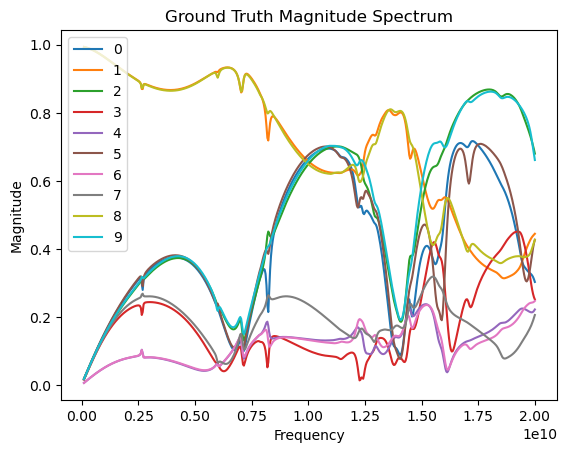

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

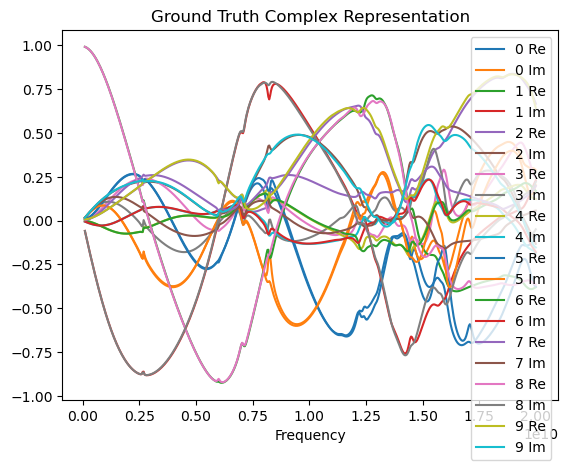

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 19

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  500
Number of Measurements:  19
Undersampling Ratio:  0.038


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 19])
y_freqs shape:  (19,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  5
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

ENSEMBLE_SIZE = 5

ensemble = [ RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0
               ) for i in range(ENSEMBLE_SIZE) ] 
for net in ensemble:
    net = net.to(device)

# Choose one network to visualize the results
net = ensemble[ENSEMBLE_SIZE // 2]

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 500])


/scratch/cluster/vgorti/miniconda3/envs/DIP/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  283848


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
LR = 2e-4
NUM_ITER = 20000
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0

NOISY_INPUT = True
USE_SGLD = False

optims = [torch.optim.Adam(ensemble[i].parameters(), lr=LR) for i in range(ENSEMBLE_SIZE)]

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr

ensemble_outputs = [None for i in range(ENSEMBLE_SIZE)]
ensemble_train_losses = [None for i in range(ENSEMBLE_SIZE)]
ensemble_train_errors = [None for i in range(ENSEMBLE_SIZE)]
ensemble_train_regs = [None for i in range(ENSEMBLE_SIZE)]
ensemble_test_mses = [None for i in range(ENSEMBLE_SIZE)]
ensemble_test_maes = [None for i in range(ENSEMBLE_SIZE)]

is_initial_fit = True
tic = time.time()
net.train()

END_NOISE_LEVELS = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

for j, net in enumerate(ensemble):

    net = net.train()
    optim = optims[j]

    START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
    END_NOISE_LEVEL = END_NOISE_LEVELS[j]
    NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

    START_LR = LR
    END_LR = 1e-5
    LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)

    if REG_HYPERPARAM > 0:
        regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
        regularizer = regularizer.to(device)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)

    train_losses = []
    train_errors = []
    if REG_HYPERPARAM > 0:
        train_regs = []

    test_mses = []
    test_maes = []

    x = x.to(device)
    y = y.to(device)

    for i in range(int(NUM_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                print("LR: ", get_lr(optim))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

    ensemble_outputs[j] = out
    ensemble_train_losses[j] = train_losses
    ensemble_train_errors[j] = train_errors
    ensemble_train_regs[j] = train_regs
    ensemble_test_mses[j] = test_mses
    ensemble_test_maes[j] = test_maes 

    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        var_output = torch.var(outputs, dim=0)

        # Sum to go to [1000]
        var_output = torch.sum(var_output, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(var_output) - 1)
                if rand_idx not in kept_inds:
                    return rand_idx

        _, idxs = torch.topk(var_output, len(var_output))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  0.9538025856018066
LR:  0.0002
NOISE LEVEL:  0.9993094630025899

ITER  999
TIME:  23.17357897758484
LR:  0.0002
NOISE LEVEL:  0.5011872336272796

ITER  1999
TIME:  54.06403994560242
LR:  0.0002
NOISE LEVEL:  0.2511886431509651

ITER  2999
TIME:  85.28479623794556
LR:  0.0002
NOISE LEVEL:  0.12589254117942225

ITER  3999
TIME:  113.73006558418274
LR:  0.0002
NOISE LEVEL:  0.06309573444802309

ITER  4999
TIME:  139.69172739982605
LR:  0.0002
NOISE LEVEL:  0.031622776601686116

ITER  5999
TIME:  165.64423298835754
LR:  0.0002
NOISE LEVEL:  0.01584893192461253

ITER  6999
TIME:  194.86829042434692
LR:  0.0002
NOISE LEVEL:  0.007943282347243643

ITER  7999
TIME:  225.9353575706482
LR:  0.0002
NOISE LEVEL:  0.003981071705535453

ITER  8999
TIME:  256.8784530162811
LR:  0.0002
NOISE LEVEL:  0.001995262314969155

ITER  9999
TIME:  283.0920388698578
LR:  0.0002
NOISE LEVEL:  0.0010000000000001527

ITER  10999
TIME:  309.06500816345215
LR:  0.0002
NOISE LEVEL:  0.00050118723362735

In [ ]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

# ensemble_outputs = np.mean(ensemble_outputs, axis=0)

# Grab all the tensors in the list and stack them into a single tensor of shape
# (ENSEMBLE SIZE, 1, S_PARAMS, FREQS)
ensemble_outputs_stacked = torch.stack(ensemble_outputs)
ensemble_train_losses_stacked = np.stack(ensemble_train_losses)
ensemble_train_errors_stacked = np.stack(ensemble_train_errors)
ensemble_test_maes_stacked = np.stack(ensemble_test_maes)
ensemble_test_mses_stacked = np.stack(ensemble_test_mses)

# Then, get the mean and variance of the actual output shape
# (1, S_PARAMS, FREQS)
out = torch.mean(ensemble_outputs_stacked, dim=0)
var_out = torch.var(ensemble_outputs_stacked, dim=0)

# Finally, get the means of all the training metrics
train_losses = np.mean(ensemble_train_losses_stacked, axis=0)
train_errors = np.mean(ensemble_train_errors_stacked, axis=0)
test_maes = np.mean(ensemble_test_maes_stacked, axis=0)
test_mses = np.mean(ensemble_test_mses_stacked, axis=0)



# print(ensemble_outputs)
# print(len(ensemble_outputs))
# print(len(ensemble_train_losses[0]))
# print(len(ensemble_train_errors[0]))
# print(len(ensemble_test_maes[0]))
# print(len(ensemble_test_mses[0]))



## Plot metrics and outputs

In [ ]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [ ]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

In [ ]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

In [ ]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Mean DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())

In [ ]:
dip_errors = x.detach().cpu() - out.detach().cpu()
print(gt_freqs.shape)
print(out.shape)
print(dip_errors.shape)
print(y.shape)

std_out = torch.sqrt(var_out)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(5,1, figsize=(24, 30))
axes = axes.flatten()

# Plot the ground truth
for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# Plot the vector fit output
for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[1].set_title("VF Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

# DIP Output, can toggle scatter and/or error bars
for i in range(N_SPARAMS):

    axes[2].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")
    axes[2].fill_between(gt_freqs, out[0,2*i].detach().cpu() - 2 * std_out[0,2*i].detach().cpu(), out[0,2*i].detach().cpu() + 2 * std_out[0,2*i].detach().cpu())
    axes[2].fill_between(gt_freqs, out[0,2*i+1].detach().cpu() - 2 * std_out[0,2*i+1].detach().cpu(), out[0,2*i+1].detach().cpu() + 2 * std_out[0,2*i+1].detach().cpu())

    axes[2].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[2].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')
axes[2].set_title("DIP Output")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

# DIP Errors
for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, torch.abs(dip_errors[0,2*i]).detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, torch.abs(dip_errors[0,2*i+1]).detach().cpu(), label=str(i)+" im")
axes[3].set_title("DIP Errors")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

# DIP Variances
for i in range(N_SPARAMS):
    axes[4].plot(gt_freqs, std_out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[4].plot(gt_freqs, std_out[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[4].set_title("DIP Variances")
axes[4].set_ylim(-0.1,0.1)
if N_SPARAMS <= 10:
    axes[4].legend(loc='upper right')


In [ ]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

### Now calculate the PSNR between the DIP output variances and the true error

In [ ]:
print(dip_errors.shape)
print(var_out.shape)

error_psnr = psnr(np.asarray(torch.abs(dip_errors).detach().cpu()), np.asarray(std_out.detach().cpu()), data_range=2)
print(error_psnr)